<a href="https://colab.research.google.com/github/AdilRaheem/Prediction-of-House-Prices-in-New-York-Boroughs-/blob/main/Prediction_of_House_Prices_in_New_York_City.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis and Prediction of Houses Prices in New York City <br>
 A notebook by Adil Raheem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Introduction

New York, often called New York City (NYC) to distinguish it from the State of New York, is the most populous city in the United States. New York City is composed of five boroughs: The Bronx, Brooklyn, Manhattan, Queens, and Staten Island. A borough is a town or district which is an administrative unit. After data cleaning, the dataset contains 4412 observations from the 5 boroughs.

The aim of this project is to predict house prices in the different boroughs of New York city using the following criteria:<br>
- Number of Bedrooms<br>
- House size <br>
- borough 


## Table of Contents
<ul>
<li><a href="#import lib">Import Libraries</a></li>
<li><a href="#import1">Import USA real estate Dataset</a></li>
<li><a href="#content3">Subsetting to New York City boroughs </a></li>
<li><a href="#content4">Import Geojson file</a></li>
<li><a href="#content5">Data Wrangling</a></li>
<li><a href="#content6">Data Exploration</a></li>
<li><a href="#content7">Split Data</a></li>
<li><a href="#content8">Build Model</a></li>
<li><a href="#content9">Results</a></li>    
</ul>

In [ ]:
pip install geopandas


In [ ]:
pip install category_encoders

<a id='import lib'></a>
## 1. Import Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from urllib.request import urlopen
import json 
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

<a id="import1"></a>
## 2. Import USA Real Estate dataset  <br>
This dataset contains Real Estate listings in the US broken by State and zip code.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WorldQuant DS Practice/usa real estate/realtor-data.csv')

<a id="content3"></a>
## 3. Subsetting to New York City boroughs <br>


In [ ]:
ny = df[df['state'] == 'New York']

In [ ]:
ny = ny[(ny['city'] == 'Queens') | (ny['city'] == 'Brooklyn') | (ny['city'] == 'Manhattan') | (ny['city'] == 'Staten Island') | (ny['city'] == 'Bronx')]

In [ ]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50563 entries, 465079 to 916782
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        50563 non-null  object 
 1   price         50563 non-null  float64
 2   bed           45918 non-null  float64
 3   bath          49082 non-null  float64
 4   acre_lot      23133 non-null  float64
 5   full_address  50563 non-null  object 
 6   street        50503 non-null  object 
 7   city          50563 non-null  object 
 8   state         50563 non-null  object 
 9   zip_code      50563 non-null  float64
 10  house_size    38858 non-null  float64
 11  sold_date     30193 non-null  object 
dtypes: float64(6), object(6)
memory usage: 5.0+ MB


<a id="content4"></a>
## 4. Import Geojson file <br>
The GeoJSON file contains all the coordinates (latitude and longitude) for every corner of the polygons of the areas you are trying to map. Each one of the coordinates in the GeoJSON file below corresponds to a bend/corner in a single ZIP Code.

In [ ]:
with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)

<a id="content5"></a>
## 5. Data Wrangling


#### Clean new york city dataset

In [ ]:
#drop duplicate rows
ny.drop_duplicates(inplace=True)

In [ ]:
#convert zipcode to object datatype
ny['zip_code'] = ny['zip_code'].astype(object)

Note that zipcode is actually a categorical feature with numerical values and should be treated as such

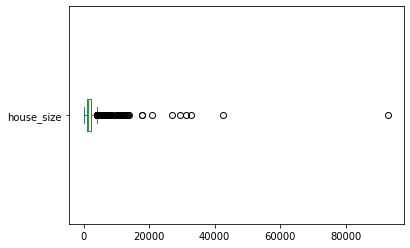

In [ ]:
# check for outliers in house size
ny.house_size.plot(kind='box', vert = False);

It can be seen from the visualization that there are outliers in house size feature of our dataset. These outliers will have to be removed as they can affect our model performance

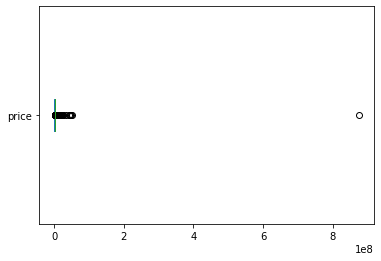

In [ ]:
ny.price.plot(kind='box', vert = False);

In [ ]:
ny['price'].describe()

count    7.016000e+03
mean     1.267164e+06
std      1.060781e+07
min      3.000000e+03
25%      4.690000e+05
50%      7.490000e+05
75%      1.250000e+06
max      8.750000e+08
Name: price, dtype: float64

It can be seen from the price summary statistics that some houses have a price value of 0 which isn't possible. Also, from the visualization, a very large outlier price can be seen. The 75th percentile is around 1.6 million while the max price value is 8.75 billion.<br>
Houses with no value and outlier prices will be removed as they can affect model performance. This analysis will therefore only include house with prices above 10,000 dollars. 

In [ ]:
ny.select_dtypes('object').nunique()

status             1
full_address    6856
street          6842
city               5
state              1
zip_code         155
sold_date       2989
dtype: int64

All columns with object datatype escept city can be seen to have low or high cardinality. This will be addressed in our model performance wrangle function

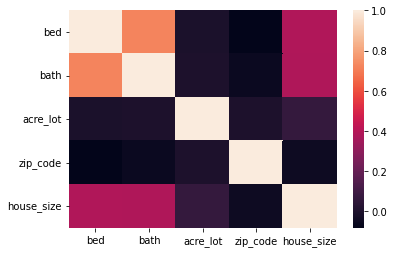

In [ ]:
correlation = df.select_dtypes('number').drop(columns='price').corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

To avoid affecting our model performance, we need to drop highly correlated columns i.e issue of multicollinearity. bath and bed columns are found to be highly correlated, one of these columns therefore needs to be dropped. The bath column (number of bathrooms) will be dropped because it has the lesser correlation value of the two columns with house price.

In [ ]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7016 entries, 465079 to 916725
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        7016 non-null   object 
 1   price         7016 non-null   float64
 2   bed           6204 non-null   float64
 3   bath          6680 non-null   float64
 4   acre_lot      3512 non-null   float64
 5   full_address  7016 non-null   object 
 6   street        7011 non-null   object 
 7   city          7016 non-null   object 
 8   state         7016 non-null   object 
 9   zip_code      7016 non-null   object 
 10  house_size    5538 non-null   float64
 11  sold_date     4102 non-null   object 
dtypes: float64(5), object(7)
memory usage: 712.6+ KB


Acre_lot column will also be excluded because half of its value are null 

### Model Performance Wrangle Function <br>
This is the final wrangling to fully prepare the data for model prediction. Wrangle function for merged data to remove outliers, columns not needed for model building, and columns that can affect our model performance 

In [ ]:
def wrangle(df):
    #df = pd.read_csv(filepath)
    # Subset data: houses in New York city above 10,000
    mask_price = (df["price"] > 10_000) & (df['price'] < 12_000_000)
    
    #
    #remove house size outliers
    low, high = df['house_size'].quantile([0.1, 0.9])
    mask_size = df['house_size'].between(low, high)
    
    df = df[ mask_price & mask_size].copy()
    
    #drop collinear columns
    df.drop(columns=['bath'], inplace =True)
    
    #rename city as borough
    df.rename(columns={'city': 'borough'}, inplace=True)
    
    #dropping low and high cardinality columns
    df.drop(columns=['state','street','full_address','status','sold_date'], inplace=True)
    
    #drop leaky column (too many null values)
    df.drop(columns = ['acre_lot'], inplace=True)
    
    #for clarity, rename bed as number of bedrooms
    df.rename(columns = { 'bed': 'num_of_bedrooms'}, inplace=True)
    
    return df

In [ ]:
#Apply the wrangle function
df = wrangle(ny)

In [ ]:
#Dataframe preview
df.head()

,price,num_of_bedrooms,borough,zip_code,house_size
465079,1575000.0,3.0,Brooklyn,11225.0,2400.0
465080,899000.0,NaN,Bronx,10466.0,1880.0
465081,890000.0,7.0,Bronx,10468.0,2824.0
465090,344900.0,2.0,Bronx,10463.0,1000.0
465095,1500000.0,8.0,Brooklyn,11221.0,2700.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4428 entries, 465079 to 916725
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            4428 non-null   float64
 1   num_of_bedrooms  4227 non-null   float64
 2   borough          4428 non-null   object 
 3   zip_code         4428 non-null   object 
 4   house_size       4428 non-null   float64
dtypes: float64(3), object(2)
memory usage: 207.6+ KB


<a id="content6"></a>
## 6. Data Exploration

### Zipcode Chloropleth map <br>
The zip_code field has the purpose of “joining” the coordinates in the GeoJSON to the zip codes in the New york city csv file

In [ ]:
import chart_studio
username='Rami10'
api_key='UQQaGSW2rVmoyKse2anA'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
#import chart_studio.plotly as py
#import chart_studio.tools as tls
#configure_plotly_browser_state()

fig = px.choropleth(df, 
                    geojson=zipcodes, 
                    locations='zip_code', 
                    color='price',
                    color_continuous_scale="Viridis",
                   
                    featureidkey="properties.ZCTA5CE10",
                    scope="usa",
                    hover_data=["borough"],
                    labels={'Cluster':'Cluster_Category'}
                          )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [ ]:
#py.plot(fig, filename="plotly_choropleth", auto_open = True)

The most expensive houses can be found in Manhattan.

In [ ]:
df.house_size.plot(kind='box', vert = False);

In [ ]:
plt.scatter(x=df['house_size'], y= df['price'])
plt.xlabel('Area [sq feet]')
plt.ylabel('Price [USD]')
plt.title('New York State: Price vs Area');

In [ ]:
df['price'].corr(df.house_size)

There is a fairly positive correlation between price and size. This means that to predict house price, house size will be a good feature to include 

In [ ]:
# Build histogram
plt.hist(df['price'])


# Label axes
plt.xlabel('Price')
plt.ylabel('Count')

# Add title
plt.title('Distribution of House Prices');



The distribution of house prices is right skewed

<a id="content7"></a>
## 7. Split Data

In [ ]:
#specify target and features 
target = 'price'
features = df.drop(columns= ['price','zip_code'])

In [ ]:
X = features   # independant features
y = df[target] # dependant variable

# # Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# confirming number of observations in each split
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

3321
1107
3321
1107


<a id="content8"></a>
## 8. Build Model

### Baseline mean absolute error

In [ ]:
# mean of target vector y_train 
y_mean = y_train.mean()

#list named y_pred_baseline that contains the value of y_mean repeated so that it's the same length at y
y_pred_baseline = [y_mean] * len(y_train)

# Calculate the baseline mean absolute error for your model.
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean house price:", round(y_mean,2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean house price: 985229.51
Baseline MAE: 558416.12


This tells us that the mean house price is `$`985,229 and if we always guessed that on average, we will be off by around `$`558,416. It also tells us that our model needs to have mean absolute error below `$`558,416 in order to be useful.

### Iterate

In [ ]:
#creating a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
        )
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [ ]:
#Evaluating model with training data
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training )
print("Training MAE:", mae_training.round(2))

Training MAE: 391120.45


Our training mean absolute error is much more smaller when compared to our baseline. Our model beats the baseline by over $169,000. That's a good indicator that it will be helpful in predicting apartment prices. The actual test is how the model performs on data that it hasn't seen before, our test set data.

In [ ]:
#Evaluating model with test data
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", mae_test.round(2))

Test MAE: 386775.82


We want the test performance metrics to be about the same as its training performance metrics. As long as the training and test performance are close to each other, you can be confident that the model will generalize well.

In [ ]:
# An array of predicted price values from our test data
y_pred_test

array([1118729.16517103, 2260982.00255802,  280199.33931497, ...,
       1547775.192114  , 1093345.08083291, 1169764.88452426])

<a id="content9"></a>
## 9. Results

In [ ]:
#intercept and coefficients for the model equation
intercept = model.named_steps['ridge'].intercept_
coefficients = model.named_steps['ridge'].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])

coefficients len: 7
[ -40063.9895852  -622667.74174075 -583671.18838958  -64059.96118338
 1406459.89210512]


In [ ]:
# feature names of your encoded data from the OneHotEncoder in the model.
feature_names = model.named_steps['onehotencoder'].get_feature_names()
print(len(feature_names))
feature_names

7


['num_of_bedrooms',
 'borough_Bronx',
 'borough_Staten Island',
 'borough_Brooklyn',
 'borough_Manhattan',
 'borough_Queens',
 'house_size']

In [ ]:
feat_imp = pd.Series(coefficients, index= feature_names)
feat_imp.head()

num_of_bedrooms         -4.006399e+04
borough_Bronx           -6.226677e+05
borough_Staten Island   -5.836712e+05
borough_Brooklyn        -6.405996e+04
borough_Manhattan        1.406460e+06
dtype: float64

### Bar Chart showing coefficients of the model

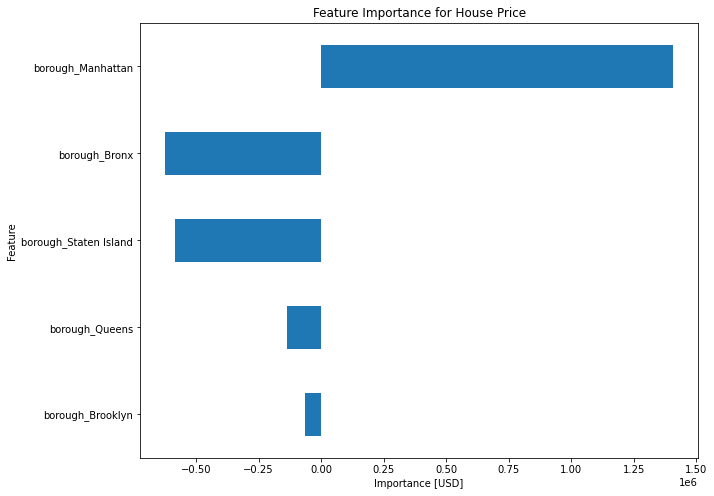

In [ ]:
#horizontal bar chart that shows the top 15 coefficients for the model, based on their absolute value
fig= plt.figure(figsize=(10,8))
feat_imp.sort_values(key=abs).tail(5).plot(kind='barh')
plt.xlabel('Importance [USD]')
plt.ylabel('Feature')
plt.title('Feature Importance for House Price');

Manhattan, the poshest of the boroughs increases predicted price of a house by almost `$`1.5 million. Manhattan is known for its supertall luxury buildings and regarded as the economic and administrative center of New york city . Being the most densely populated and geograpically smallest of the boroughs, it can said that the increase in price is attributed to demand often surpassing supply.<br>
Others, which are more of a working-class borough are seen to decrease predicted price of a house.

### Dynamic Dashboard for Price Prediction

In [ ]:
def make_prediction(num_of_bedrooms,borough, house_size):
    data = {
        'num_of_bedrooms': num_of_bedrooms,
        'borough': borough,
        'house_size': house_size,
    }
    df = pd.DataFrame(data, index= [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [ ]:
interact(
    make_prediction,
    
     num_of_bedrooms=IntSlider(
        min=X_train["num_of_bedrooms"].min(),
        max=X_train["num_of_bedrooms"].max(),
        value=X_train["num_of_bedrooms"].mean(),
    ),
   
     borough=Dropdown(options=sorted(X_train["borough"].unique())),
    
     house_size=FloatSlider(
        min=X_train["house_size"].min(),
        max=X_train["house_size"].max(),
        value=X_train["house_size"].mean(),
    )
   
);

interactive(children=(IntSlider(value=3, description='num_of_bedrooms', max=21, min=1), Dropdown(description='…